# 分析結果まとめ

## 概要
- **到達度：**
  - 数値実験で手法の裏付けをしようと思いましたが、時間オーバーのため、ほとんど裏付けできていません。
  - 「こんな手法考えました。適応したらこんな結果になりました」程度のアドホックな内容となっています。。。
- **提案手法：**
  - MobileNetV2でデータセットの一部（全データの10%にあたる約600件）を学習データとして分類モデルを作り、残りのデータに対してモデルを適用し、アノテーションされたクラスではない別のクラスに所属する確率を算出することで、アノテーションミスの寡多を評価する手法を考案した。
  - Fashion MNISTのデータセットで同様の手法を試したところ（数値実験）、団体毎のアノテーションミスの寡多が評価できることが確認できた。**←と思ってましたが、実験の設計によくない部分があり、正しく検証できたとは言えないことがわかりました。。**
- **アノテーション団体の評価結果：**
  - 本手法でアノテーション団体を評価したところ、**アノテーター0>アノテーター2>アノテーター1**となった（左から順にアノテーションミスが少ない）。
    - dataset/N/の画像のアノテーションを実施したアノテーターを、アノテーターNとしています
- **今後の課題：**
  - 学習データの割合や、アノテーションミスと見做す閾値の設定方法の確立（今回はえいやで設定）
  - 評価結果の妥当性を、アノテーションミスを含んだ対象データを使って評価する方法の確立（今回はやっていない）
  - アノテーション対象外のクラスの混入の検出（今回想定したのは与えられた11クラスのどれかに属するはずだが、別のクラスに割り当てられてしまうケースのみ）

## 問題設定
- 課題
  - アノテーターによるアノテーションミスがある
  - アノテーションミスを評価するために、全てのデータを確認するにはコストがかかる
  - 一方、アノテーションミスが多いデータを使うことで、予測モデルの精度が落ちてビジネス上、損失を被る可能性がある
- 達成したいこと
  - **①アノテーションミスのあるデータの特定**
    - アノテーションミスそのものが特定できれば、データをクレンジングできるし、業者の費用対効果*も計測しやすい
      - *例：正しくアノテーションできたデータの件数/業者のコスト
  - **②アノテーションミスの「件数」の予測**
    - 業者毎のアノテーションミスの件数が予測できれば、データ品質に起因する精度低下やビジネス影響が評価できる可能性がある
  - **③アノテーションミスの「寡多」の予測**
    - 業者のコストが同じ状況であれば、アノテーションミスの「寡多」が分かれば、最良の業者を特定できる
- 今回やったこと
  - ①〜③と色々と可能性を提示して、簡単な検証を試みたものの、残課題があまりにも多く、今回の評価では最も難易度が低そうな③のアプローチを取りました。。

## 提案手法
- Deep Learningをベースとした以下3つの手法を検討
  - **①MobileNetV2**
    - imagenetで学習済みMobileNetのモデルをファインチューニングして多クラス分類モデルを構築する
    - 上記モデルを適用して、画像データがアノテーターにより割り当てられたクラスに属する確率を算出する
    - 上記の確率を用いて、アノテーションミスのある「データ」特定や、アノテーションミスの「件数」推定、「寡多」推定を行う
  - **②MobileNetV2+L2-constrained Softmax Loss**
    - imagenetで学習済みMobileNetの最終層を削除し、L2-constrained Softmax層を結合したモデルでファインチューニングして多クラス分類モデルを構築する。以下、MobileNetV2と同様の手順で実施する
  - **MobileNetV2+L2-constrained Softmax Loss+LOF**　→ボツ
    - モデル構築までは「MobileNetV2+L2-constrained Softmax Loss」と同様
    - 最終層の1つ手前の層のoutputをLOF（Local Outlier Factor）にかけて、異常スコアを得る
      - アノテーションされたクラス毎に、LOFを実行し、そのクラスに属性ていない可能性が高い画像を特定する
    - 上記の異常スコアを用いて、アノテーションミスのある「データ」特定や、アノテーションミスの「件数」推定、「寡多」推定を行う

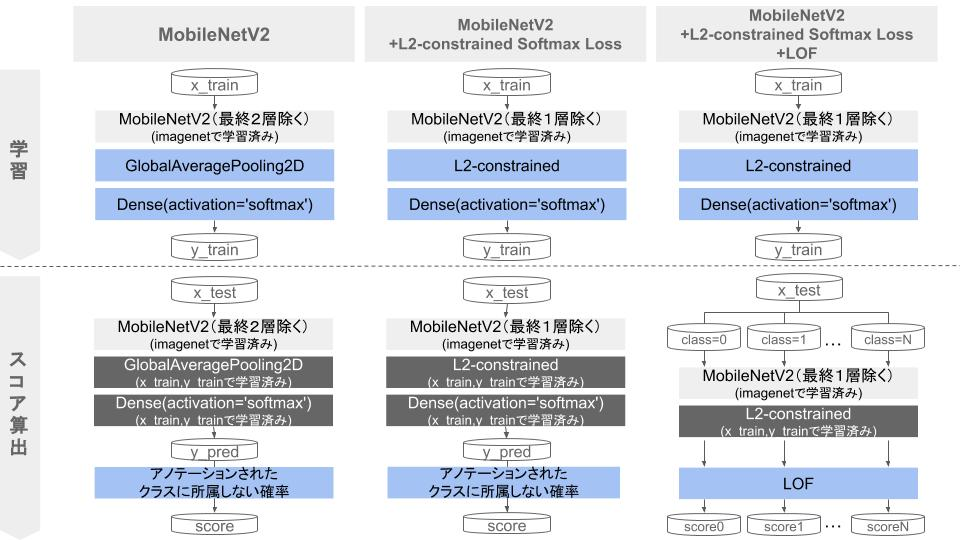

- Fashion MNISTのデータ7000件を学習し、7000件でテストする実験（×1回のみ）を実施したところ、**③MobileNetV2+L2-constrained Softmax Loss+LOF**では精度が出ない(AUC≒0.5)ことが判明したため、以降では、**①MobileNetV2**、**②MobileNetV2+L2-constrained Softmax Loss**の2つの手法を比較することとした。
  - ※下記図表は、MobileNetV2層の重みも固定せずに今回の学習データで学習させた場合の結果です。その後、MobileNetV2層の重みをimagenetで固定したファインチューニングの方が精度の良い結果が得られることが分かったので、以降ではMobileNetV2層の重みをimagenetで固定したモデルを使うようにしています

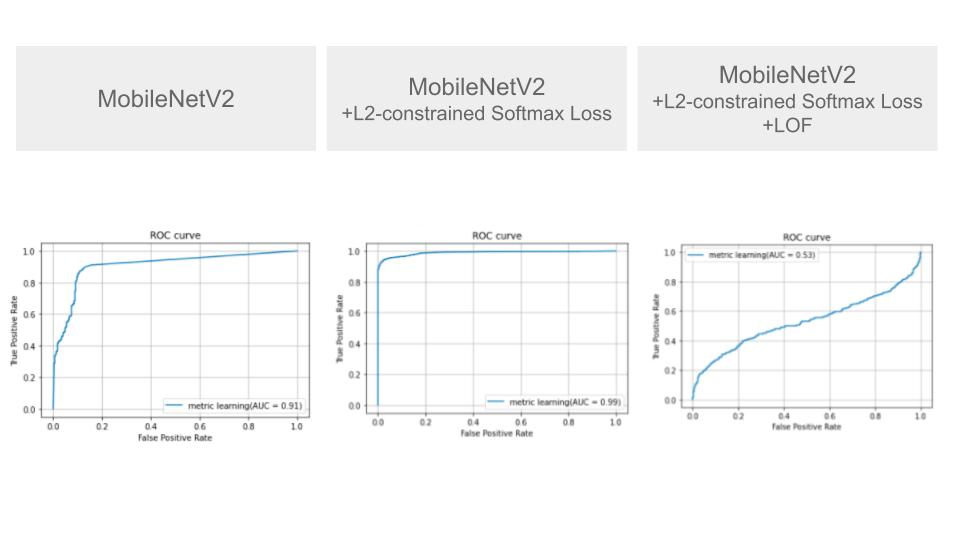

## 数値実験
- 以下3つのCaseで、達成したいこと①〜③それぞれが達成できるかを検証する
  - **Case1: アノテーションミスを含まないデータで学習させる**→やったけど問題設計がよくなかった
  - **Case2: アノテーションミスを含むデータで学習させる**→やったけど問題設計がよくなかった
  - **Case3: アノテーションミスを含むデータで評価する**→タイムオーバーで未実施
- データセットの設定：
  - Fashion MNISTからランダムに7000件のデータを抽出
  - 7000件をランダムに3つの仮想のアノテーターに割り当てる
  - アノテーターがそれぞれ1%、4%、7%の確率で、アノテーションミスを生じるよう設定し、真のクラスとは別に、アノテーターによりアノテーションされたクラスのデータを準備する

- Case1: アノテーションミスを含まないデータで学習させる
    - 実施目的：
      - アノテーションが正しく行えているデータが何件あれば、アノテーションミス、件数、グループ毎の寡多を検出できるか検証するため
        - 人命に関わるような高い予測精度が求められる問題では、予測精度はもちろんのこと、予測精度やアノテーターの評価方法にも高い精度が求められるため、一手間かけてでも正しいデータセットを作る工程は不可欠ではないかと考えた
        - 例えば、今回で言えばSarumanの絵が書かれたTシャツが混入していた。問題設定によってはOtherと扱うべきだが、このような微妙な違いを評価するためには、「正しい」データセットによる評価が必要と思われる
    - 実施内容：
      - 7000件のFashion MNISTのデータのうち、N件（100, 500, 1000）を学習データとしてモデルを構築する
      - 残り7000-N件にアノテーションミスのデータを混入させ、アノテーションミス、件数、グループ毎の寡多を検出できるか検証する
    - 結果：
      - MobileNetV2+L2-constrained Softmax Lossよりも、MobileNetV2の方がパフォーマンスが良さそう
      - 100件の「正しいデータセット」があれば、アノテーションミスの検出ができそうな感触（え、本当？）
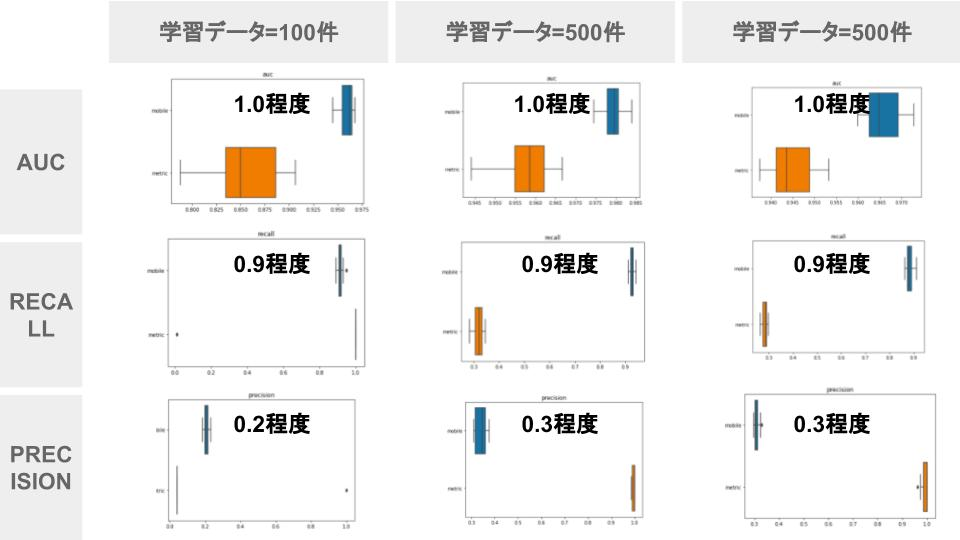
    - 残課題：
      - imagenetでファインチューニングしたのが、よくなかったと思われる。
        - 気づいた時には、時すでに遅しでしたが、imagenetの学習データのfashion mnistが含まれていて、fashion mnistのデータに対しては、少量データのファインチューニングで対応できてしまう説です。。
      - 加えて、Fashion MNISTは一つの写真に一つのクラスしか写っていない簡単な問題なので、現実問題で考えると、もっと画像が必要かもしれない。だとすると、実際のデータセットを使って、正しいデータセットの過不足を評価する仕組みを考える必要あり

- Case2： アノテーションミスを含むデータで学習させる
  - 実施目的：
    - ノイズを含んだデータでモデルを学習させたモデルを使って、アノテーションミス、件数、グループ毎の寡多を検出できるか検証するため
  - 実施内容：
    - 7000件のFashion MNISTのデータのうち、500件を学習データとしてモデルを構築する
    - 残り6500件にアノテーションミスのデータを混入させ、アノテーションミス、件数、グループ毎の寡多を検出できるか検証する
  - 結果：
    - 精度良さそうだったが、imagenetのファインチューニングの影響だと思われる。。（詳細省略）

## 対象データにおける手法適用
- 方針：
  - 検証方法に不備があることが分かったため、提出用のランク付けには、最も難易度が低いと思われる**「③アノテーションミスの「寡多」の予測」**のアプローチをとることに
- 実施内容：
  - 下記のプロセスを15回実施して各回でのアノテータの評価値を取得。15回のアノテーターの評価値の中央値で、アノテーターのランク付けを行った
    - ①データセットの10%（約600件）を学習用のデータとしてランダムに抽出して、MobileNetV2のファインチューニングによりモデルを構築する
    - ②残りの90%のデータセットに予測モデルを適用して、各クラスに所属する確率を算出する
    - ③上記プロセス②の確率値を用いて、アノテーターに割り当てられたクラスに所属しない確率を算出する（1-アノテータに割り当てられたクラスに所属する確率
    - ④アノテーター毎に、以下２種類のスコアを算出し、アノテーター１のスコアで、アノテーター2、3のスコアを割り算して正規化したものをアノテーターの評価値とした（高いほどミスが多い可能性がある）
      - A. プロセス③で算出したスコアの合計値
      - B. プロセス③で算出したスコアが閾値（今回は0.95とした）を超えたデータの件数
- 結果：
  - 手法A、Bともに、**アノテーター0<アノテーター2<アノテーター1**となった（左から順にアノテーションミスが少ない）。
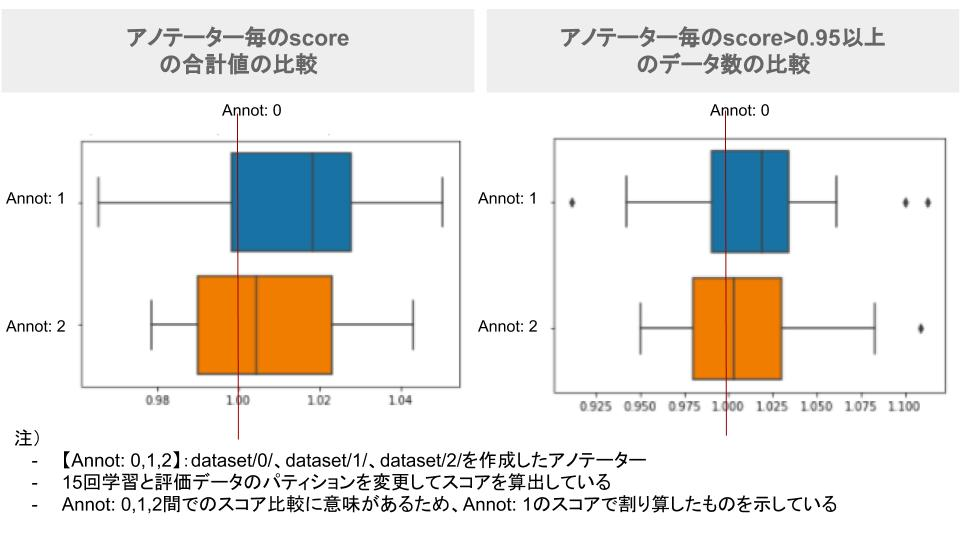

## 最後に
- **今後の課題（概要再掲）：**
  - 学習データの割合や、アノテーションミスと見做す閾値の設定方法の確立（今回はえいやで設定）
  - 評価結果の妥当性を、アノテーションミスを含んだ対象データを使って評価する方法の確立（今回はやっていない）
  - アノテーション対象外のクラスの混入の検出（今回想定したのは与えられた11クラスのどれかに属するはずだが、別のクラスに割り当てられてしまうケースのみ）

- **改善や発展の可能性：**
  - **部分的にデータのアノテーションの真偽を人手で確認し、そのデータをもとに分類モデルを構築することで、アノテーションミスの疑いがあるデータを検出しデータクレンジングに使えないか？**
    - 今回、imagenetを使ってファインチューニングしたため、十分に検証できたとは言えないが、①アノテーションミスを含んだデータのクレンジングが同時に行えてしまう、②「SarumanTシャツ」と「Saruman」のような微妙な違いを評価できる可能性がある、という点でこのような手法のニーズが大きいと思われる
  - **Metrics Lerningで画像を特徴量ベクトルに変換することで、想定していた11クラス外の画像データが混入している場合に対応できないか？**
    - 今回は、あるクラスに別のクラスのデータが混入しているかどうかを検出するために、Metric Learning+LOFを適応したが、精度が出なかった
    - 考えられる原因は、データ不足。クラス毎にデータを分割して、それぞれのクラスのデータでLOFを行ったため、データが不足したのではないか、と考える
- **感想：**
  - 今回初めて画像解析に触れて、落とし穴の多さを痛感しました。
    - 技術以前の問題設定の段階では、「ビジネス観点で、どのようにアノテーターの評価を行うのが良いのか？」、「テストデータにすらノイズが含まれている状況で、どのように評価を行えばいいのか？」と言った点が難しいと感じましたし、結構時間を使って考えました。
    - 技術面も難しくて、「そもそも画像を分類するにはどんな手法を使えばいいのか？」、「画像の異常検知にはどのような手法があるのか？」と言った基本的なことから解決する必要があり、大変でした。今回のファインチューニング問題のように、正しく技術的な中身を理解せずに使うと痛い目にあうことが分かったのは、良い収穫だったと思います。。
  - 最後に、本イベントを主宰・運営して下さった、AI-SCHOLARのみなさん、特に、中村さん、榎本さんに御礼申し上げます。

## 参考文献

- 直接参考にしたもの
  - [「弱異常検知」と他の異常検知、違いはなにか？](https://qiita.com/shinmura0/items/1af83f5a5857d50cabc2)
  - [Weakly-anomaly-detection360](https://github.com/shinmura0/Weakly-anomaly-detection/blob/master/WeaklyAnomalyDetection.ipynb)
  - [【まとめ】ディープラーニングを使った異常検知](https://qiita.com/shinmura0/items/06d81c72601c7578c6d3)
  - [t-SNEを理解して可視化力を高める](https://qiita.com/g-k/items/120f1cf85ff2ceae4aba)
- 間接的に参考にしたもの
  - [モダンな深層距離学習 (deep metric learning) 手法: SphereFace, CosFace, ArcFace](https://qiita.com/yu4u/items/078054dfb5592cbb80cc)
  - [ディープラーニングを使った画像の異常検知　－論文と実装－](https://qiita.com/shinmura0/items/cfb51f66b2d172f2403b)
  - [[Keras]MobileNetV2+ArcFaceを使ってペットボトルを分類してみた!](https://qiita.com/noritsugu_yamada/items/2e049cd7a8fd77eee0f5)
  - [分類器で学習できるMetric learningを簡潔なコードで試す](https://qiita.com/daisukelab/items/d7ebfe8d7ade18def967)

# 各種設定

## 基本ライブラリ

In [ ]:
# 数値分析ライブラリインポート
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd
import xgboost as xgb
import time
import random

# 可視化モジュール
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習モジュール
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# keras関連モジュール
import keras
from keras.applications import MobileNetV2
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras import backend as K
from keras.utils import np_utils

# 画像解析用
from PIL import Image
import cv2

#外部データ
from keras.datasets import fashion_mnist

# その他
from datetime import datetime
import os

#TSNEによる可視化
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 定数の設定

In [ ]:
#各種設定
##ファイルの置き場所、カテゴリの名称
files_path = './drive/My Drive/dataset/'
groups = ['0', '1', '2']
categories = ['Afghan Hound', 'Fried Chicken', 'Muffin', 'Sheepdog',
              'chihuahua', 'Labradoodle', 'Puppy', 'Teddy Bear', 'cookie', 'Mop', 'Saruman']

categories_and_numbers = {'Afghan Hound':0, 'Fried Chicken':1, 'Muffin':2, 'Sheepdog':3, 
                          'chihuahua':4, 'Labradoodle':5, 'Puppy':6, 'Teddy Bear':7, 'cookie':8, 'Mop':9, 'Saruman':10}

##画像ファイルのサイズ
pict_size = (96, 96, 3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

##近傍点の数
n_neighbors = 7

##画像データフレーム作成済み（１：作成済み、０：未作成）
image_data_flag = 1

## 画像処理

In [ ]:
def get_picture_data(file_path, pict_size):
  '''file pathから画像データを取得し整形する関数'''
  #ファイルの読み込み
  im = Image.open(file_path)
  #グレースケール変換（３チャンネルで表現するために再度RGB化する）
  im_gray = im.convert('L').convert("RGB")
  #リサイズ
  im_resize = np.array(im_gray.resize([pict_size[0],pict_size[1]]))
  # 一次元化
  im_gray_ravel = im_resize.ravel()
  del im
  del im_gray
  del im_resize
  return im_gray_ravel
  #plt.imshow(im_gray, cmap=plt.cm.gray_r)

def get_data_set(files_path, groups, categories, pict_size):
  '''全団体の画像データを取得して1つのデータフレームにする関数'''
  #データフレーム の初期化
  df_all_pictures = DataFrame(columns=[i for i in range(pict_size[0]*pict_size[1]*pict_size[2])]).assign(
    category=None,
    group=None
  )
  #カテゴリ・グループ毎に画像の読み込み
  for category in categories:
    for group in groups:
      path = files_path +group +'/' + category
      files = os.listdir(path)
      file_paths = [path+'/' + file for file in files]
      picture_data = np.array([get_picture_data(file_path, pict_size) for file_path in file_paths])
      df_pict = DataFrame(picture_data).assign(
          category = category,
          group = group
      )
      df_all_pictures = df_all_pictures.append(df_pict).reset_index(drop=True)
      del picture_data
      del df_pict
  return df_all_pictures

def random_choose(x, y, size):
  '''numpy配列x, y（yは空でもOK）からランダムにN個を取得する'''
  np.random.seed(seed=32)
  number = np.random.choice(np.arange(0, len(x)), size, replace=False)
  return_x, return_y = [], []

  if len(y) > 0:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
          return_y.append(y[i])
      return np.array(return_x), return_y
  else:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
      return np.array(return_x)

def make_test_train_split(df_all_pictures):
  #テスト学習のスプリット
  from sklearn.model_selection import train_test_split
  df_all_picture_train, df_all_picture_test = train_test_split(df_all_pictures, 
                                                               stratify = df_all_pictures.category, 
                                                               random_state=0, 
                                                               test_size=0.06)#全体の6%のうち、2%が異常、4%が正常
  #ラベル付
  df_all_picture_train['train_test']='train'
  df_all_picture_test['train_test']='test'
  #再結合
  df_all_picture_merge = df_all_picture_train.append(df_all_picture_test).reset_index(drop=True)
  del df_all_picture_train
  del df_all_picture_test
  del df_all_pictures
  return df_all_picture_merge

def make_test_labels(df_all_pictures, categories):
  np.random.seed(seed=32)
  '''66%に対してアノテーションされた元のラベルを、
  残り34%に対してアノテーションされていないラベルをランダムに割り当てる'''

  def make_test_label(random_value, original_label, categories):
    if(random_value<0.66): return original_label
    else: return random.choice( list(set(categories)-set(original_label)) )

  def modify_label(test_label, train_test, original_label):
    if(train_test=='train'): return original_label
    else: return test_label
  
  df_all_pictures = df_all_pictures.assign(
      test_label = lambda df: df.category.apply(
          lambda x: make_test_label(random.random(), x, categories))
    ).assign(
      test_label = lambda df: np.vectorize(modify_label)(df.test_label, df.train_test, df.category),
      actual = lambda df: (df.category == df.test_label)*2-1
    ).reset_index(drop=True)

  return df_all_pictures

def get_fashion_mnist(df_all_pictures, pict_size):
  '''df_all_picturesに外部のデータをノイズとして混入させる'''
  np.random.seed(seed=32)
  #外部の画像データの取り込み
  (x_train_fashion, y_train_fashion), (_, _) = fashion_mnist.load_data()

  #画像サイズの変更
  x_train_fashion = np.array([
            cv2.resize(
                cv2.cvtColor(x, cv2.COLOR_GRAY2RGB),
                dsize= (pict_size[0], pict_size[1]) ) 
            for x in x_train_fashion
  ])

  #ランダムサンプル
  x_train_fashion, y_train_fashion = random_choose(x_train_fashion, y_train_fashion, 200)
  x_train_fashion = np.array([x.ravel() for x in x_train_fashion])

  #マスターデータに統合
  df_all_pictures = df_all_pictures.append(
      DataFrame(columns = np.array([str(i) for i in range(pict_size[0]*pict_size[1]*pict_size[2])]),
                data= x_train_fashion).assign(
        category = 'others',
        group = None,
        train_test = 'test',
        actual = -1,
        test_label = [random.choice(categories) for i in range(len(x_train_fashion))],
    )
  ).reset_index(drop=True)
  return df_all_pictures

## 分類

In [ ]:
def detect_mis_annotetion(df_picture, df_partition, categories):
  '''LOFによる分類の実行'''

  def detect_mis_annotetion_for_category(df_category_pictures):
    '''あるカテゴリーについて異常のある画像を検出する'''
    clf = LocalOutlierFactor(n_neighbors=n_neighbors)
    pred = clf.fit_predict(df_category_pictures)
    score = clf._decision_function(df_category_pictures)
    return (pred, score)

  results_naive_lof = DataFrame(columns=['pred', 'score', 'id', 'category', 'group', 'train_test', 'test_label', 'actual'])
  for category in categories:
    df_category_pictures = df_picture[df_partition.test_label==category]
    df_category_partition = df_partition[df_partition.test_label==category]
    (pred, score) = detect_mis_annotetion_for_category(df_category_pictures)
    result = DataFrame({
        'pred': pred,
        'score': score,
        'id': df_category_partition.index,
        'category': df_category_partition.category,
        'group': df_category_partition.group,
        'train_test': df_category_partition.train_test,
        'test_label': df_category_partition.test_label,
        'actual': df_category_partition.actual
    })
    results_naive_lof = results_naive_lof.append(result)
    del result
    del df_category_pictures
  return results_naive_lof

#metrics learningによる特徴量抽出
def get_metrics(df_all_pictures, pict_size, categories, categories_and_numbers):
  '''テストラベルを教師としてmetric learningのモデルを構築して、モデルによる特徴量を返す関数'''
  input_shape = pict_size
  classes = len(categories)
  batchsize = 128
  alpha = 0.5

  # データ整形
  y_train_sum = df_all_pictures.test_label.values
  y_train_sum = np.array([categories_and_numbers[y] for y in y_train_sum])
  y_train_sum = np_utils.to_categorical(y_train_sum)

  X_train_sum = df_all_pictures.iloc[:,0:pict_size[0]*pict_size[1]*pict_size[2]].values
  X_train_sum = np.array([
      x.reshape(pict_size) for x in X_train_sum
  ])

  X_train_sum = X_train_sum.astype(int)/225.

  # モデル構築
  mobile = MobileNetV2(include_top=True, input_shape=input_shape, alpha=alpha, weights='imagenet')
  ## 最終層削除
  model = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
  ## L2層と全結合層を付ける
  c = keras.layers.Lambda(lambda xx: 5*(xx)/K.sqrt(K.sum(xx**2)))(model.output) #metric learning
  c = Dense(classes, activation='softmax')(c)
  model = Model(inputs=model.input,outputs=c)

  # 学習
  #model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(amsgrad=True),
                metrics=['accuracy'])
  hist = model.fit(X_train_sum,
                    y_train_sum,
                    batch_size=128,
                    epochs=50,
                    verbose=0)
  
  # 予測（特徴量の抽出）
  # 最終層の削除
  print(len(model.layers))
  #model.layers.pop()
  model2 = Model(inputs=model.input, outputs=model.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
  print(len(model2.layers))
  # 特徴量の抽出
  y_train_re = model2.predict(X_train_sum, batch_size=1)

  return y_train_re, model, model2

## 評価

In [ ]:
def plot_auc(y_true, y_score):
  '''aucカーブをプロットする'''
  #FPR, TPR(, しきい値) を算出
  fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_score)

  #AUC
  auc = metrics.auc(fpr, tpr)

  #プロット
  plt.plot(fpr, tpr, label='metric learning(AUC = %.2f)'%auc)
  plt.legend()
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)
  plt.show()
  return auc

def plot_tsne(x, y):
  '''TSNEによる可視化'''
  tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
  X_embedded = tsne.fit_transform(x)
  ddf = pd.concat([y, pd.DataFrame(X_embedded, columns = ['col1', 'col2'])], axis = 1)
  colors =  ["r", "g", "b", "c", "m", "y", "k", "orange","pink", "gray", "brown", "gold"]
  plt.figure(figsize = (30, 30))
  for i , v in enumerate(Series(y).unique()):
      tmp_df = ddf[ddf['category'] == v]
      plt.scatter(tmp_df['col1'],  
                  tmp_df['col2'],
                  label = v,
                  color = colors[i])
  plt.legend(fontsize = 30)

def show_images(df_all_pictures, ids, pict_size):
  i=0
  len_id = len(ids)
  n_col = int(len_id/5)+1
  plt.figure(figsize=(20,3*n_col))
  for id in ids.astype(int):
    im = df_all_pictures.iloc[id,0:pict_size[0]*pict_size[1]*pict_size[2]]
    im = np.reshape(np.array(im), pict_size).astype(int)
    ax = plt.subplot(n_col,5,i+1)
    ax.imshow(im, cmap=plt.cm.gray_r)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(title='actual='+df_all_pictures.iloc[id,:].category.astype(str)+', test='+df_all_pictures.iloc[id,:].test_label.astype(str))
    #plt.title('actual='+df_all_pictures.iloc[id,:].category+', test='+df_all_pictures.iloc[id,:].test_label)
    i+=1

# 提案手法

## 簡易テスト用データセット

In [ ]:
# データの初期設定
n_data = 7000
mis_annotation_ratio = [0.02, 0.04, 0.06]
mis_annotation_dict = {'0':0.02, '1':0.04, '2':0.06}
categories_2 = [0,1,2,3,4,5,6,7,8,9]
categories_and_numbers_2 = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}

# データのロード
(x_train_fashion, y_train_fashion), (_, _) = fashion_mnist.load_data()
# n_data*2件のデータ抽出
x_train_fashion, y_train_fashion = random_choose(x_train_fashion, y_train_fashion, n_data*2)
# 画像サイズの変更
x_train_fashion = np.array([
          cv2.resize(
              cv2.cvtColor(x, cv2.COLOR_GRAY2RGB),
              dsize= (pict_size[0], pict_size[1]) ) 
          for x in x_train_fashion
])
X_train_sum = x_train_fashion.astype(int)/255.

#yの整形
y_train_sum_v = np.array([categories_and_numbers_2[y] for y in y_train_fashion])
y_train_sum = np_utils.to_categorical(y_train_sum_v)

y_train_sum_v_add, y_train_sum_add, x_train_fashion_add = y_train_sum_v[7000:], y_train_sum[7000:], X_train_sum[7000:]

# 異常ラベルの混入
y_true = y_train_sum_v_add
y_test = y_true + np.array([ (i<n_data*0.05)*5 for i in range(len(y_true))])
y_test = np.array([y%10 for y in y_test])

4423680/4422102 [==============================] - 0s 0us/step


## 簡易テスト: MobileNetV2

0.6035714285714285


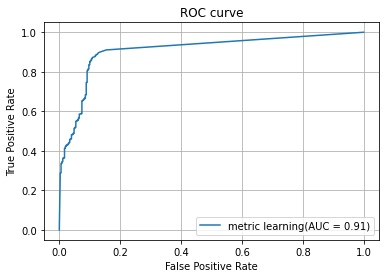

0.9083918367346938

In [ ]:
input_shape = pict_size
classes = len(categories_2)
batchsize = 128
alpha = 0.5

# モデル構築
mobile = MobileNetV2(include_top=False, input_shape=input_shape, alpha=alpha, weights='imagenet')
### 最終層削除
model = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
### L2層と全結合層を付ける
model.trainable = True
model = keras.Sequential([
  model,
  GlobalAveragePooling2D(),
  Dense(classes, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])

# 学習（7000件を学習、7000件をテストに）
hist = model.fit(X_train_sum[:7000],
                  y_train_sum[:7000],
                  batch_size=128,
                  epochs=50,
                  verbose=0)

# 予測・評価
y_score = model.predict(X_train_sum[7000:])
y_pred = DataFrame(y_score).T.idxmax()
df_eval = DataFrame({'pred':y_pred, 'act':y_train_sum_v[7000:]}).assign(dif = lambda df: df.pred == df.act)
acc = df_eval.dif.sum()/df_eval.dif.count()
print(acc)

# 異常度=1-対象カテゴリのスコアの算出
df_score = DataFrame(y_score)
df_label = DataFrame(np_utils.to_categorical(y_test))
anomaly_score = df_score[0]*0.
for i in range(10):
  anomaly_score += df_score[i]*df_label[i]
anomaly_score = 1- anomaly_score

# AUC
plot_auc(y_true = (y_true == y_test)*2-1, 
         y_score= -anomaly_score)

In [ ]:
mobile.summary()

Model: "mobilenetv2_0.50_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
________________________________________________________________________________

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
_______________________________________________________________________________________

##簡易テスト: MobileNetV2+L2-constrained Softmax Loss

8339456/8331712 [==============================] - 0s 0us/step
0.8132857142857143


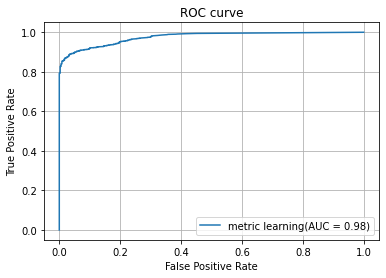

0.9751224489795918

In [ ]:
input_shape = pict_size
classes = len(categories_2)
batchsize = 128
alpha = 0.5

# モデル構築
mobile = MobileNetV2(include_top=True, input_shape=input_shape, alpha=alpha, weights='imagenet')
### 最終層削除
model = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
### L2層と全結合層を付ける
model.trainable = True
c = keras.layers.Lambda(lambda xx: 5*(xx)/K.sqrt(K.sum(xx**2)))(model.output) #metric learning
c = Dense(classes, activation='softmax')(c)
model = Model(inputs=model.input,outputs=c)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])

# 学習（7000件を学習、7000件をテストに）
hist = model.fit(X_train_sum[:7000],
                  y_train_sum[:7000],
                  batch_size=128,
                  epochs=50,
                  verbose=0)

# 予測・評価
y_score = model.predict(X_train_sum[7000:])
y_pred = DataFrame(y_score).T.idxmax()
df_eval = DataFrame({'pred':y_pred, 'act':y_train_sum_v[7000:]}).assign(dif = lambda df: df.pred == df.act)
acc = df_eval.dif.sum()/df_eval.dif.count()
print(acc)

# 異常度=1-対象カテゴリのスコアの算出
df_score = DataFrame(y_score)
df_label = DataFrame(np_utils.to_categorical(y_test))
anomaly_score = df_score[0]*0.
for i in range(10):
  anomaly_score += df_score[i]*df_label[i]
anomaly_score = 1- anomaly_score

# AUC
plot_auc(y_true = (y_true == y_test)*2-1, 
         y_score= -anomaly_score)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
_______________________________________________________________________________________

## 簡易テスト：MobileNetV2+L2-constrained Softmax Loss+LOF

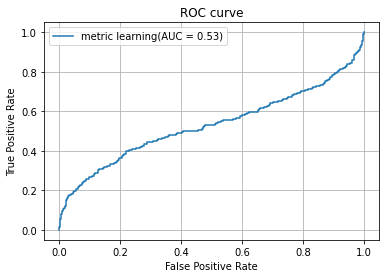

0.5298921589688508

In [ ]:
# 特徴量抽出
model2 = Model(inputs=model.input, outputs=model.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
y_futures = model2.predict(x_train_fashion_add, batch_size=1)

# 異常検知精度の確認
results_metric_and_lof = detect_mis_annotetion(
    y_futures,
    DataFrame({
        'category': y_true,
        'group': None,
        'test_label':y_test,
        'actual': (np.array(y_true) == y_test)*2-1,
        'train_test':'test'
    }),
    categories_2)

# AUC →　リフトの傾向から、少量の異常を検出するには有効だが、多くの異常を検出しようとするのにはむかなさそう
plot_auc(y_true = -results_metric_and_lof[results_metric_and_lof.train_test=='test'].actual.astype(int), 
         y_score= -results_metric_and_lof[results_metric_and_lof.train_test=='test'].score)

In [ ]:
model2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
_______________________________________________________________________________________

# 数値実験

### 関数などの定義

In [ ]:
# データの初期設定
n_data = 7000
mis_annotation_ratio = [0.01, 0.04, 0.07]
mis_annotation_dict = {'0':0.02, '1':0.04, '2':0.06}
categories_2 = [0,1,2,3,4,5,6,7,8,9]
categories_and_numbers_2 = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}

def get_fashion_mnist_data(n_data):
  ''''fashion mnistデータのロード'''
  # データのロード
  (x_fashion, y_fashion), (_, _) = fashion_mnist.load_data()
  # n_data件のデータ抽出
  x_fashion, y_fashion = random_choose(x_fashion, y_fashion, n_data)
  # 画像サイズの変更
  x_fashion = np.array([
            cv2.resize(
                cv2.cvtColor(x, cv2.COLOR_GRAY2RGB),
                dsize= (pict_size[0], pict_size[1]) ) 
            for x in x_fashion
  ])
  x_fashion = x_fashion.astype(int)/255.

  # groupの割り当て
  group = np.array([int((i*3)/n_data) for i in range(n_data)])
  # アノテーションミスの有無（-1:ミス、1:ミスなし）
  mis_annotation = np.array([
                                  ( (0*n_data/3<=i)&(i<(int(n_data/3))*(0+mis_annotation_ratio[0])) )|
                                  ( (1*n_data/3<=i)&(i<(int(n_data/3))*(1+mis_annotation_ratio[1])) )|
                                  ( (2*n_data/3<=i)&(i<(int(n_data/3))*(2+mis_annotation_ratio[2])) )
                                  for i in range(n_data)])*(-2)+1

  # アノテーションミス時のラベル（元のラベル以外の別のラベルに割り当てる）
  random_labels = np.array([
                                  (label+random.choice([1,2,3,4,5,6,7,8,9]))%10
                                  for label in y_fashion])
  # アノテーションミスを含まない真のラベル
  y_true = np.array(y_fashion)
  # アノテーションミスを含むラベルの作成
  y_annot = (mis_annotation>0)*y_fashion+(mis_annotation<0)*random_labels
  return x_fashion, y_true, y_annot, mis_annotation, group

def random_choose(x, y, size):
  '''numpy配列x, y（yは空でもOK）からランダムにN個を取得する'''
  np.random.seed(seed=32)
  number = np.random.choice(np.arange(0, len(x)), size, replace=False)
  return_x, return_y = [], []

  if len(y) > 0:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
          return_y.append(y[i])
      return np.array(return_x), return_y
  else:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
      return np.array(return_x)

def get_train_index(n_train):
  '''学習データとテストデータの分割'''
  random_index = np.array([i for i in range(n_data)]) #学習とテストに分割する用のインデックス
  random.shuffle(random_index)
  is_train = (random_index < n_train) #学習:True, テスト:False
  return is_train

def plot_auc(y_true, y_score):
  '''aucカーブをプロットする'''
  #FPR, TPR(, しきい値) を算出
  fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_score)

  #AUC
  auc = metrics.auc(fpr, tpr)

  #プロット
  plt.plot(fpr, tpr, label='metric learning(AUC = %.2f)'%auc)
  plt.legend()
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)
  plt.show()
  return auc

def learn_cnn(is_train, is_metric, includes_mis_annotation=False):
  '''学習済みモデルを構築する'''
  x_train = x_fashion[is_train]
  if includes_mis_annotation:
    y_train = np_utils.to_categorical(y_annot[is_train])
  else:
    y_train = np_utils.to_categorical(y_true[is_train])

  input_shape = pict_size
  classes = len(categories_2)
  batchsize = 128
  alpha = 0.5

  # モデル構築
  mobile = MobileNetV2(include_top=is_metric, input_shape=input_shape, alpha=alpha, weights='imagenet')
  ## 最終層削除
  model = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
  model.trainable = False
  if is_metric:
    c = keras.layers.Lambda(lambda xx: 5*(xx)/K.sqrt(K.sum(xx**2)))(model.output) #metric learning
    c = Dense(classes, activation='softmax')(c)
    model = Model(inputs=model.input,outputs=c)
  else:
    model = keras.Sequential([
      model,
      GlobalAveragePooling2D(),
      Dense(classes, activation='softmax')
    ])
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(amsgrad=True),
                metrics=['accuracy'])
  # 学習
  hist = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)
  return model

def evaluate_cnn_model(model,  is_train):
  '''評価: MobileNetV2&MobileNetV2+Metric Learning'''
  x_test = x_fashion[is_train==False]
  y_test = np_utils.to_categorical(y_true[is_train==False])
  y_test_annot = np_utils.to_categorical(y_annot[is_train==False])

  ## 予測
  y_score = model.predict(x_test)

  ## ACC
  y_pred = DataFrame(y_score).T.idxmax()
  df_eval = DataFrame({'y_pred':y_pred, 'y_true':y_true[is_train==False]}).assign(dif = lambda df: df.y_pred == df.y_true)
  acc_score = df_eval.dif.sum()/df_eval.dif.count()

  ## AUC
  df_score = DataFrame(y_score)
  df_label = DataFrame(y_test_annot)
  anomaly_score = df_score[0]*0.
  for i in range(10):
    anomaly_score += df_score[i]*df_label[i]
  anomaly_score = 1- anomaly_score

  auc_score =  plot_auc(y_true = mis_annotation[is_train==False], 
          y_score= -anomaly_score)

  ## total anomaly score by group
  anomaly_score_by_group = DataFrame({
      'group':group[is_train==False],
      'anomaly_score':anomaly_score
  }).groupby('group').anomaly_score.sum()

  ## anomaly counts estimate by group
  anomaly_counts_estimate_by_group = DataFrame({
      'group':group[is_train==False],
      'is_anomaly':anomaly_score>0.95
  }).groupby('group').is_anomaly.sum()

  ## actual anomaly counts by group
  actual_anomaly_counts_by_group = DataFrame({
      'group':group[is_train==False],
      'is_anomaly':(mis_annotation[is_train==False])==-1
  }).groupby('group').is_anomaly.sum()

  ## 混同行列
  confusion_matrix = DataFrame({
      'pred':(anomaly_score>0.95)*(-2)+1,
      'actual':mis_annotation[is_train==False],
      'v' :1
  }).pivot_table(
      index = 'actual',
      columns = 'pred',
      values = 'v',
      aggfunc = 'count'
  )

  ## 再現率recall
  recall = confusion_matrix.iloc[0,0]/confusion_matrix.iloc[0,:].sum()

  ## 適合率precision
  precision = confusion_matrix.iloc[0,0]/confusion_matrix.iloc[:,0].sum()

  return (acc_score, auc_score, anomaly_score_by_group, anomaly_counts_estimate_by_group, 
          actual_anomaly_counts_by_group, confusion_matrix, recall, precision)

## Case1: アノテーションミスを含まないデータで学習させる

In [ ]:
# データロード
x_fashion, y_true, y_annot, mis_annotation, group = get_fashion_mnist_data(n_data)

# アノテーションミスの発生状況
DataFrame({
    'y_annot' : y_annot,
    'group' : group,
    'y_true' : y_true,
    'actual' : mis_annotation
}).pivot_table(
    index = 'group',
    columns = 'actual',
    values = 'y_annot',
    aggfunc = 'count'
).assign(
    mis_annotation_ratio = lambda df: df[-1]/(df[1]+df[-1])
)

actual,-1,1,mis_annotation_ratio
group,,,
0,24,2310,0.010283
1,93,2240,0.039863
2,163,2170,0.069867


number=0
roc curve mobilenet


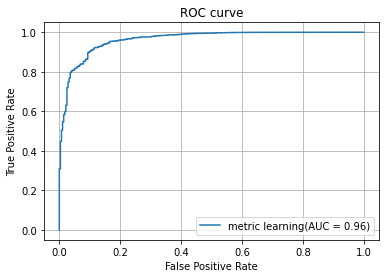

roc curve metric


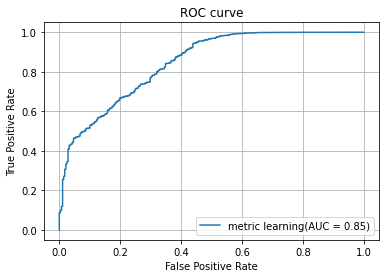

number=1
roc curve mobilenet


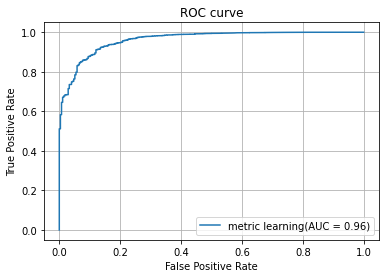

roc curve metric


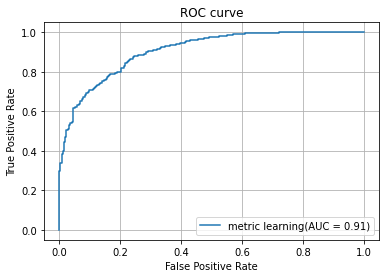

number=2
roc curve mobilenet


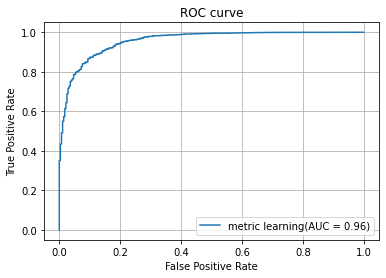

roc curve metric


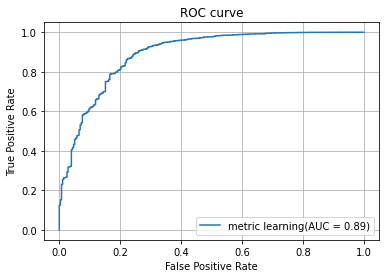

number=3
roc curve mobilenet


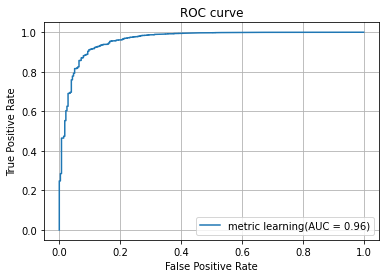

roc curve metric


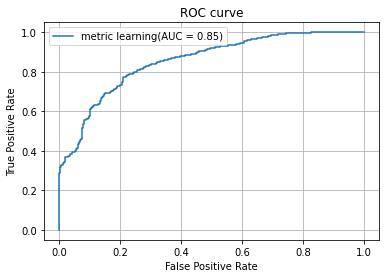

number=4
roc curve mobilenet


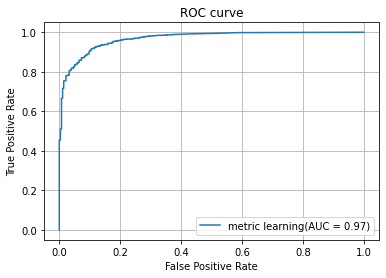

roc curve metric


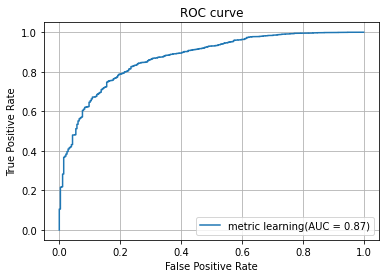

number=5
roc curve mobilenet


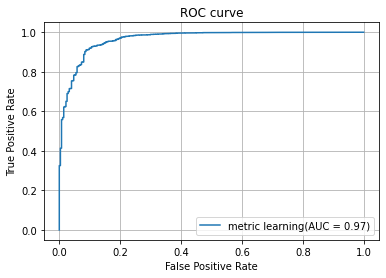

roc curve metric


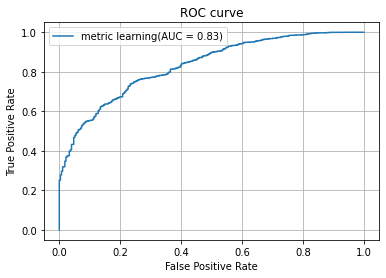

number=6
roc curve mobilenet


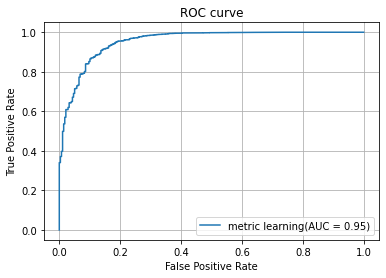

roc curve metric


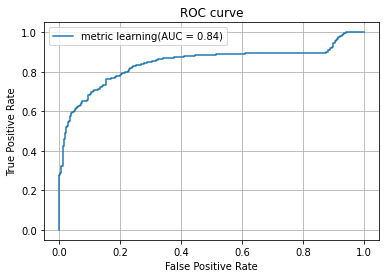

number=7
roc curve mobilenet


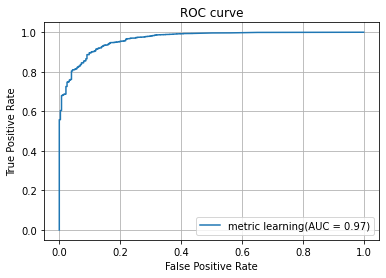

roc curve metric


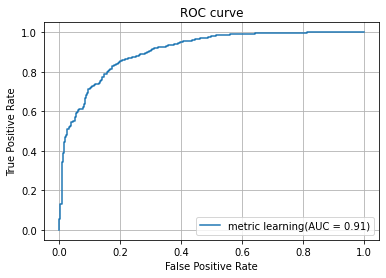

number=8
roc curve mobilenet


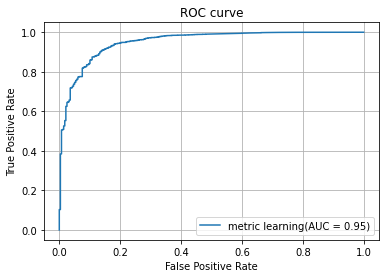

roc curve metric


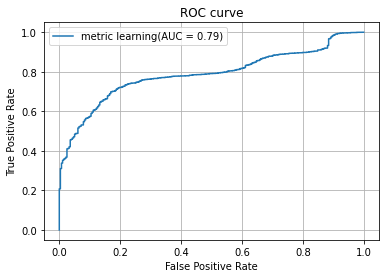

number=9
roc curve mobilenet


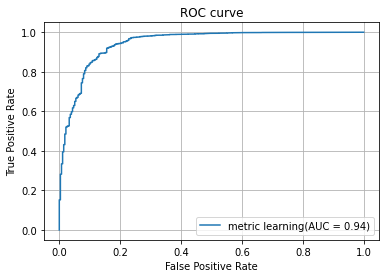

roc curve metric


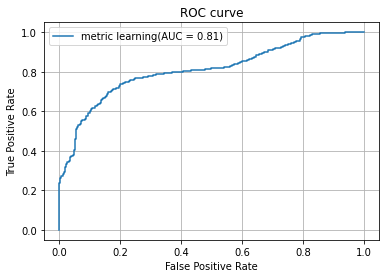

In [ ]:
# n_train = 100の場合
result_mobile_list = []
result_metric_list = []
for i in range(10):
  is_train = get_train_index(n_train = 100)
  print('number='+str(i))
  model_mobile = learn_cnn(is_train, is_metric=False)
  model_metric = learn_cnn(is_train, is_metric=True)
  
  print('roc curve mobilenet')
  result_mobile = evaluate_cnn_model(model_mobile,  is_train)
  result_mobile_list.append(result_mobile)
  
  print('roc curve metric')
  result_metric = evaluate_cnn_model(model_metric,  is_train)
  result_metric_list.append(result_metric)

Text(0.5, 1.0, 'g2_vs_g3_count_list_mobile')

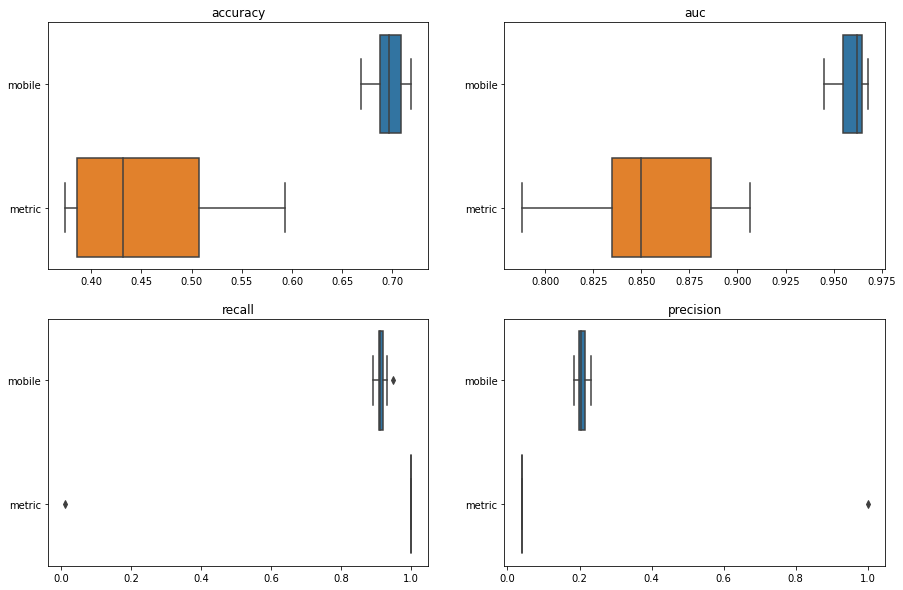

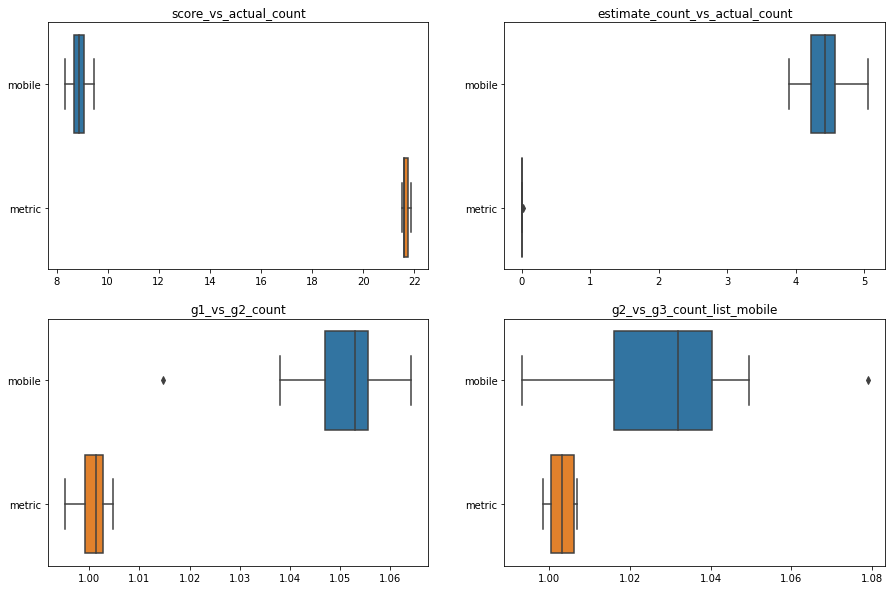

In [ ]:
# グラフ用データ整備
acc_list_mobile = np.array([res[0] for res in result_mobile_list])
acc_list_metric = np.array([res[0] for res in result_metric_list])

auc_list_mobile = np.array([res[1] for res in result_mobile_list])
auc_list_metric = np.array([res[1] for res in result_metric_list])

recall_list_mobile = np.array([res[6] for res in result_mobile_list])
recall_list_metric = np.array([res[6] for res in result_metric_list])

precision_list_mobile = np.array([res[7] for res in result_mobile_list])
precision_list_metric = np.array([res[7] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[acc_list_mobile,acc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('accuracy')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[auc_list_mobile,auc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('auc')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[recall_list_mobile,recall_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('recall')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[precision_list_mobile,precision_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('precision')


# グラフ用データ整備
score_vs_actual_count_list_mobile = np.array([res[2].sum()/res[4].sum() for res in result_mobile_list])
score_vs_actual_count_list_metric = np.array([res[2].sum()/res[4].sum() for res in result_metric_list])

estimate_count_vs_actual_count_list_mobile = np.array([res[3].sum()/res[4].sum() for res in result_mobile_list])
estimate_count_vs_actual_count_list_metric = np.array([res[3].sum()/res[4].sum() for res in result_metric_list])

g1_vs_g2_count_list_mobile = np.array([res[2][1]/res[2][0] for res in result_mobile_list])
g1_vs_g2_count_list_metric = np.array([res[2][1]/res[2][0] for res in result_metric_list])

g2_vs_g3_count_list_mobile = np.array([res[2][2]/res[2][1] for res in result_mobile_list])
g2_vs_g3_count_list_metric = np.array([res[2][2]/res[2][1] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[score_vs_actual_count_list_mobile,score_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('score_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[estimate_count_vs_actual_count_list_mobile,estimate_count_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('estimate_count_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g1_vs_g2_count_list_mobile,g1_vs_g2_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g1_vs_g2_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g2_vs_g3_count_list_mobile,g2_vs_g3_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g2_vs_g3_count_list_mobile')

number=0
roc curve mobilenet


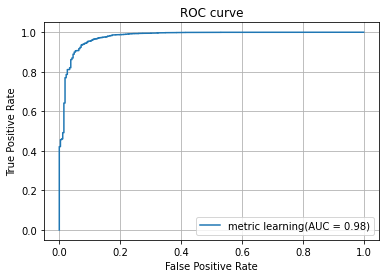

roc curve metric


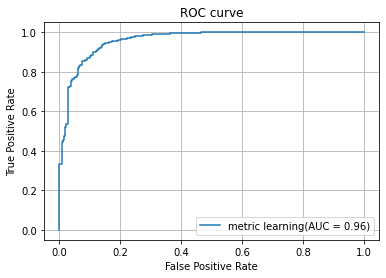

number=1
roc curve mobilenet


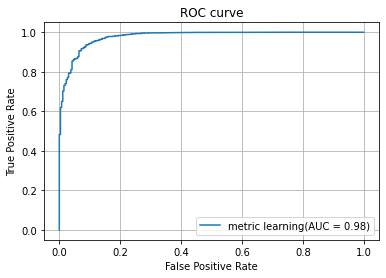

roc curve metric


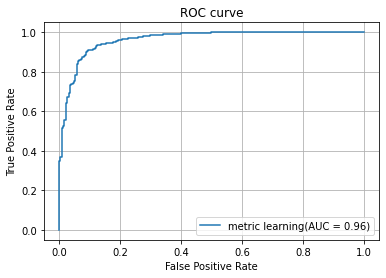

number=2
roc curve mobilenet


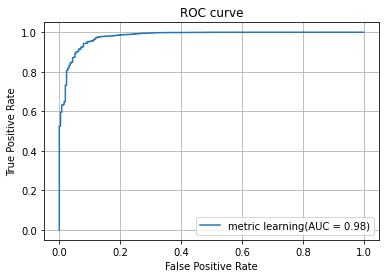

roc curve metric


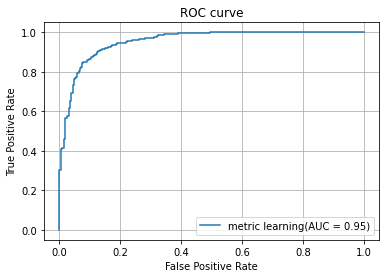

number=3
roc curve mobilenet


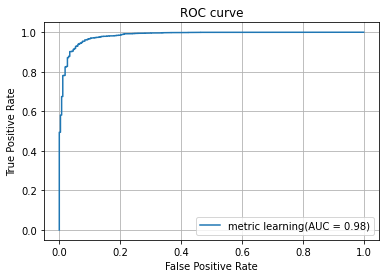

roc curve metric


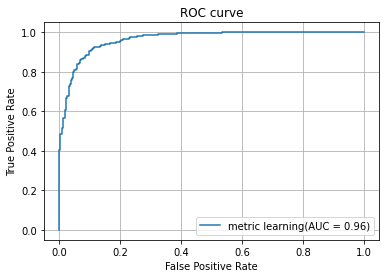

number=4
roc curve mobilenet


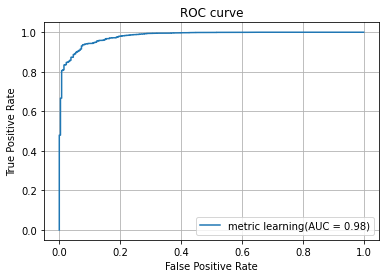

roc curve metric


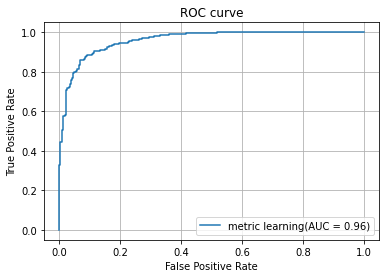

number=5
roc curve mobilenet


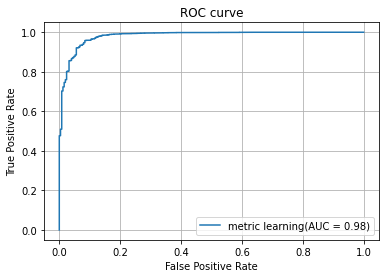

roc curve metric


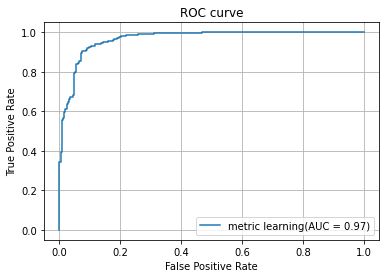

number=6
roc curve mobilenet


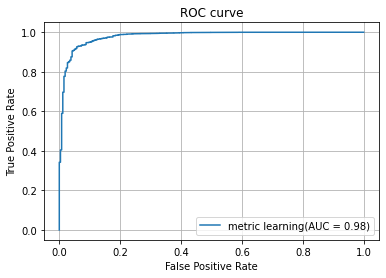

roc curve metric


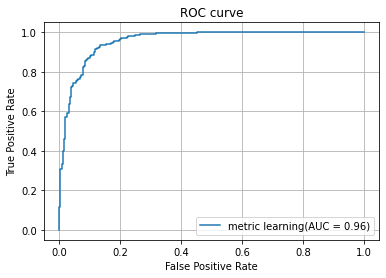

number=7
roc curve mobilenet


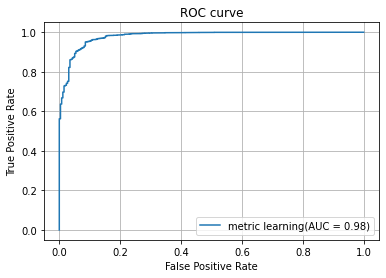

roc curve metric


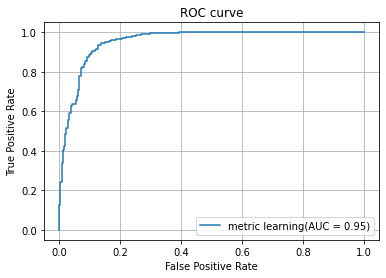

number=8
roc curve mobilenet


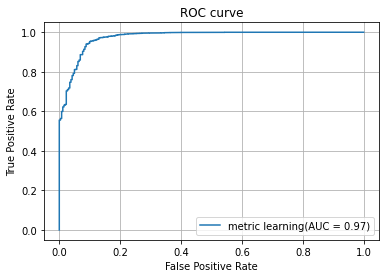

roc curve metric


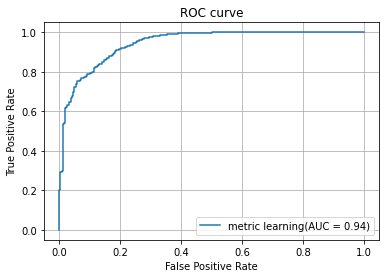

number=9
roc curve mobilenet


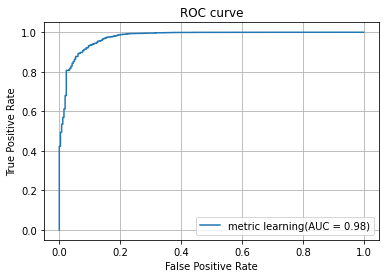

roc curve metric


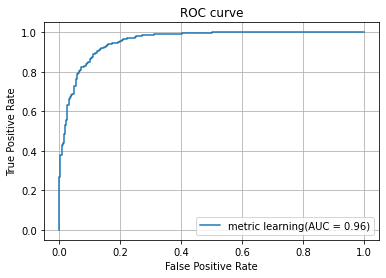

In [ ]:
# n_train = 500の場合
x_fashion, y_true, y_annot, mis_annotation, group = get_fashion_mnist_data(n_data)
result_mobile_list = []
result_metric_list = []
for i in range(10):
  is_train = get_train_index(n_train = 500)
  print('number='+str(i))
  model_mobile = learn_cnn(is_train, is_metric=False)
  model_metric = learn_cnn(is_train, is_metric=True)
  
  print('roc curve mobilenet')
  result_mobile = evaluate_cnn_model(model_mobile,  is_train)
  result_mobile_list.append(result_mobile)
  
  print('roc curve metric')
  result_metric = evaluate_cnn_model(model_metric,  is_train)
  result_metric_list.append(result_metric)

Text(0.5, 1.0, 'g2_vs_g3_count_list_mobile')

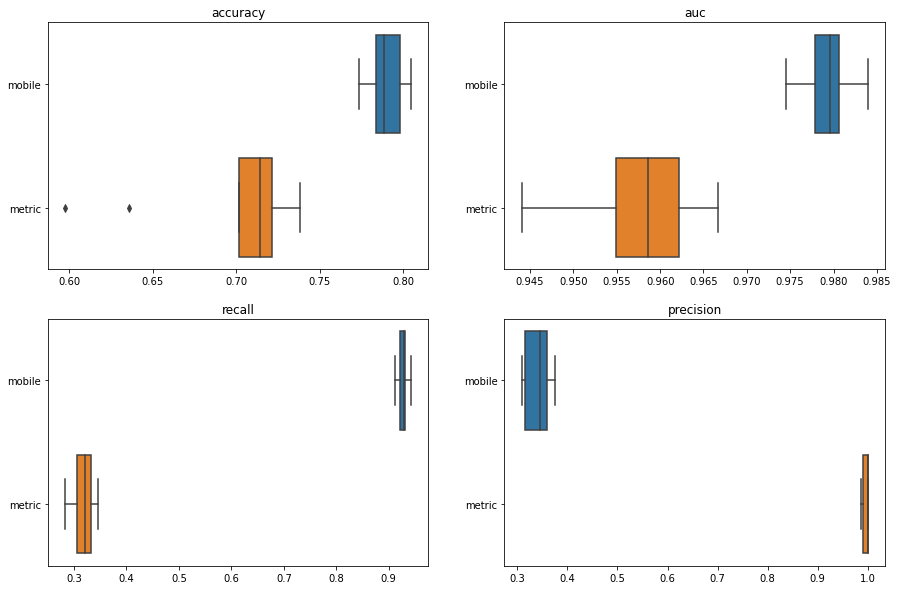

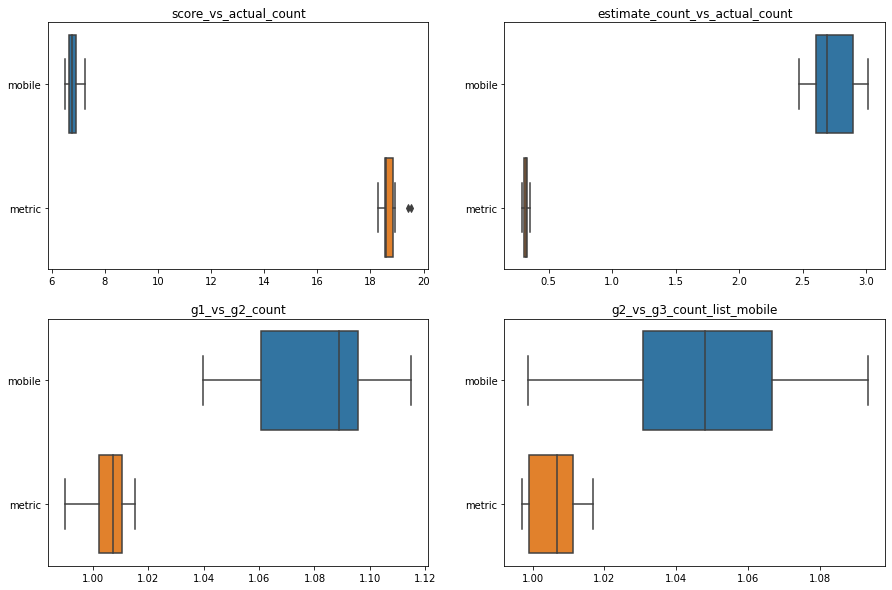

In [ ]:
# グラフ用データ整備
acc_list_mobile = np.array([res[0] for res in result_mobile_list])
acc_list_metric = np.array([res[0] for res in result_metric_list])

auc_list_mobile = np.array([res[1] for res in result_mobile_list])
auc_list_metric = np.array([res[1] for res in result_metric_list])

recall_list_mobile = np.array([res[6] for res in result_mobile_list])
recall_list_metric = np.array([res[6] for res in result_metric_list])

precision_list_mobile = np.array([res[7] for res in result_mobile_list])
precision_list_metric = np.array([res[7] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[acc_list_mobile,acc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('accuracy')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[auc_list_mobile,auc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('auc')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[recall_list_mobile,recall_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('recall')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[precision_list_mobile,precision_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('precision')


# グラフ用データ整備
score_vs_actual_count_list_mobile = np.array([res[2].sum()/res[4].sum() for res in result_mobile_list])
score_vs_actual_count_list_metric = np.array([res[2].sum()/res[4].sum() for res in result_metric_list])

estimate_count_vs_actual_count_list_mobile = np.array([res[3].sum()/res[4].sum() for res in result_mobile_list])
estimate_count_vs_actual_count_list_metric = np.array([res[3].sum()/res[4].sum() for res in result_metric_list])

g1_vs_g2_count_list_mobile = np.array([res[2][1]/res[2][0] for res in result_mobile_list])
g1_vs_g2_count_list_metric = np.array([res[2][1]/res[2][0] for res in result_metric_list])

g2_vs_g3_count_list_mobile = np.array([res[2][2]/res[2][1] for res in result_mobile_list])
g2_vs_g3_count_list_metric = np.array([res[2][2]/res[2][1] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[score_vs_actual_count_list_mobile,score_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('score_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[estimate_count_vs_actual_count_list_mobile,estimate_count_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('estimate_count_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g1_vs_g2_count_list_mobile,g1_vs_g2_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g1_vs_g2_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g2_vs_g3_count_list_mobile,g2_vs_g3_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g2_vs_g3_count_list_mobile')

## Case2: アノテーションミスを含むデータで学習させる

number=0
roc curve mobilenet


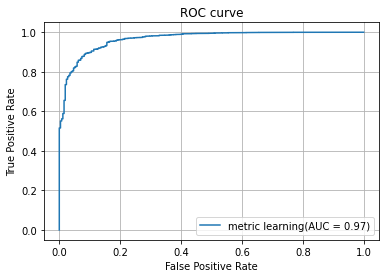

roc curve metric


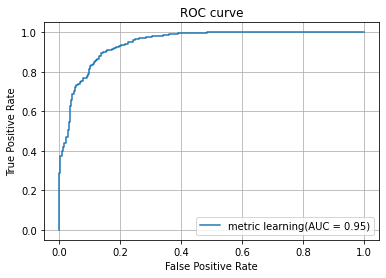

number=1
roc curve mobilenet


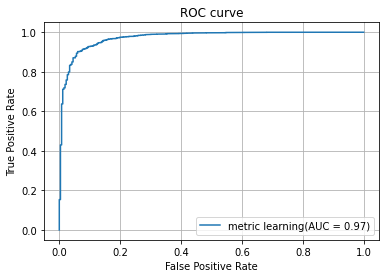

roc curve metric


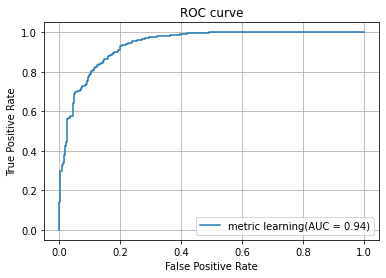

number=2
roc curve mobilenet


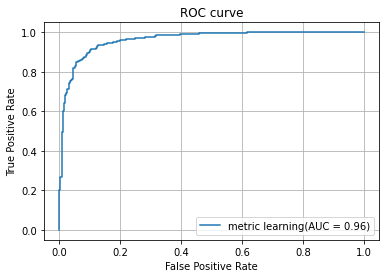

roc curve metric


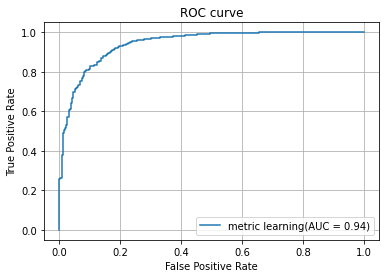

number=3
roc curve mobilenet


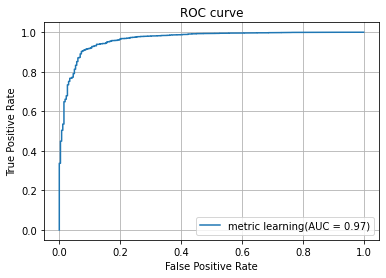

roc curve metric


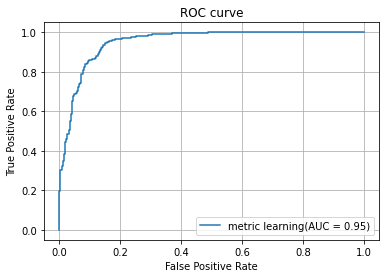

number=4
roc curve mobilenet


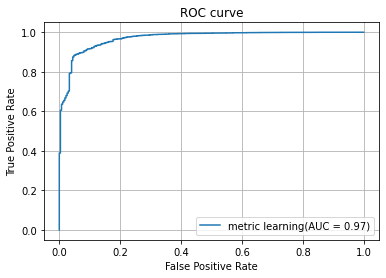

roc curve metric


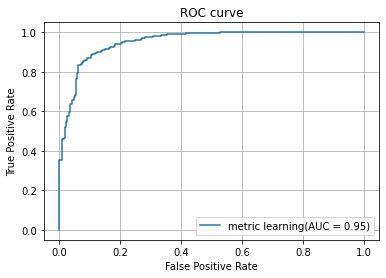

number=5
roc curve mobilenet


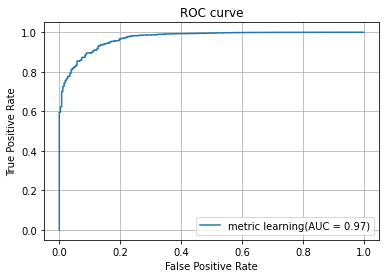

roc curve metric


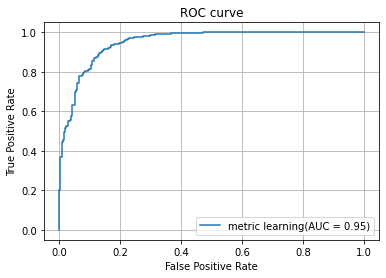

number=6
roc curve mobilenet


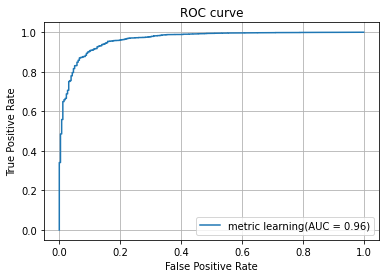

roc curve metric


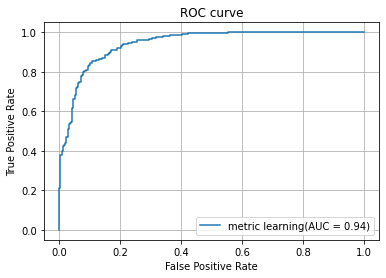

number=7
roc curve mobilenet


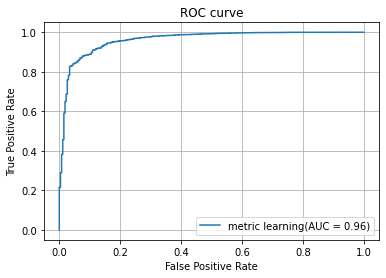

roc curve metric


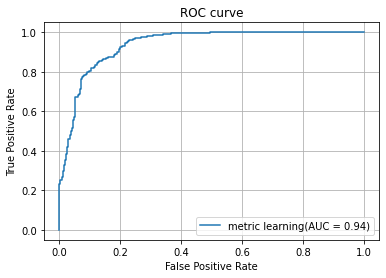

number=8
roc curve mobilenet


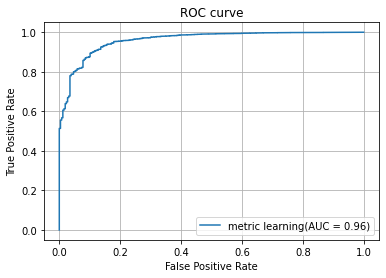

roc curve metric


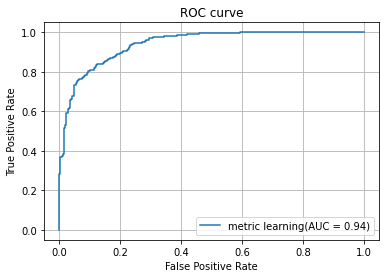

number=9
roc curve mobilenet


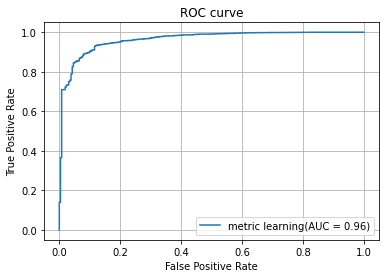

roc curve metric


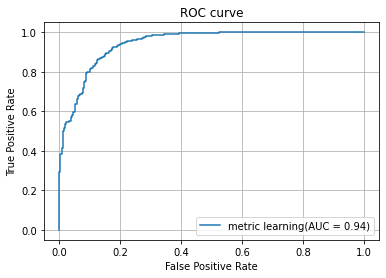

In [ ]:
# n_train = 500の場合
x_fashion, y_true, y_annot, mis_annotation, group = get_fashion_mnist_data(n_data)
result_mobile_list = []
result_metric_list = []
for i in range(10):
  is_train = get_train_index(n_train = 500)
  print('number='+str(i))
  model_mobile = learn_cnn(is_train, is_metric=False, includes_mis_annotation=True)
  model_metric = learn_cnn(is_train, is_metric=True, includes_mis_annotation=True)
  
  print('roc curve mobilenet')
  result_mobile = evaluate_cnn_model(model_mobile,  is_train)
  result_mobile_list.append(result_mobile)
  
  print('roc curve metric')
  result_metric = evaluate_cnn_model(model_metric,  is_train)
  result_metric_list.append(result_metric)

Text(0.5, 1.0, 'g2_vs_g3_count_list_mobile')

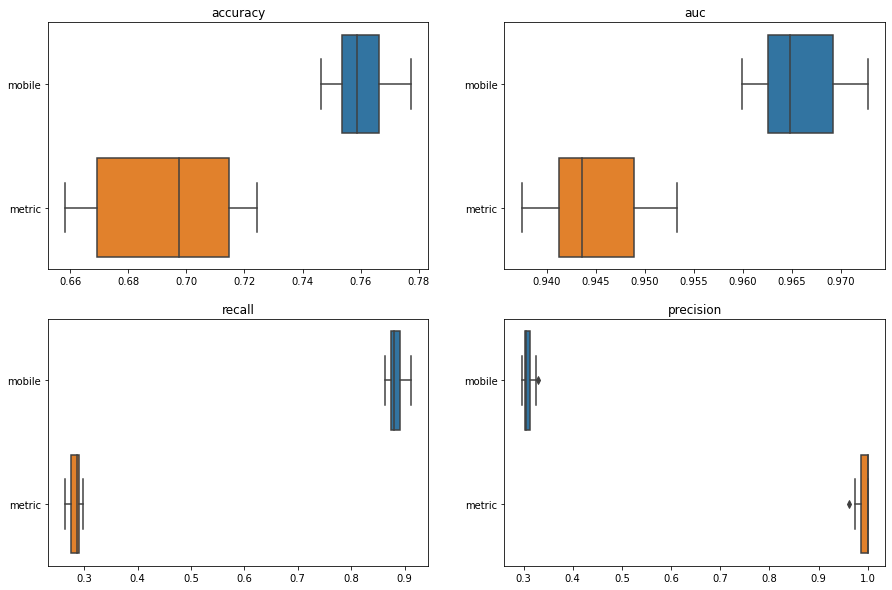

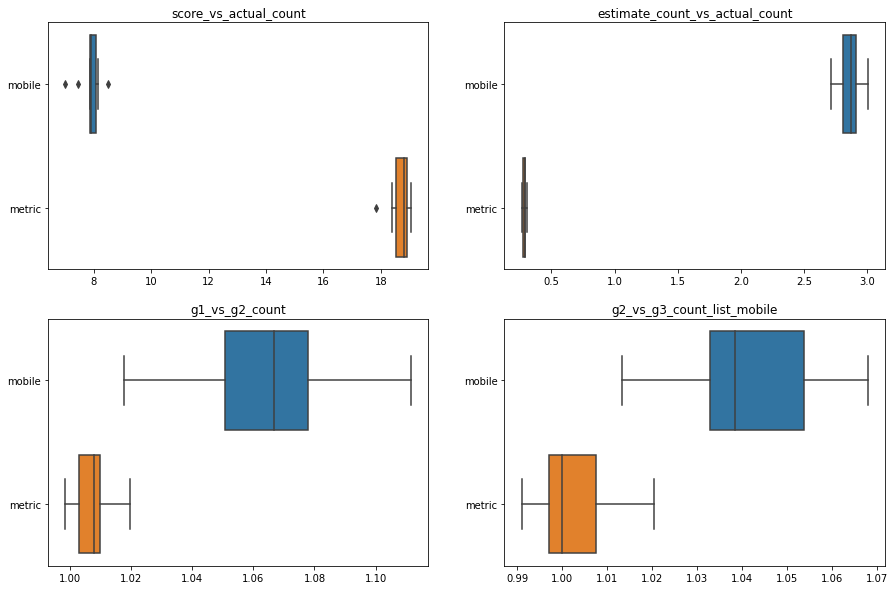

In [ ]:
# グラフ用データ整備
acc_list_mobile = np.array([res[0] for res in result_mobile_list])
acc_list_metric = np.array([res[0] for res in result_metric_list])

auc_list_mobile = np.array([res[1] for res in result_mobile_list])
auc_list_metric = np.array([res[1] for res in result_metric_list])

recall_list_mobile = np.array([res[6] for res in result_mobile_list])
recall_list_metric = np.array([res[6] for res in result_metric_list])

precision_list_mobile = np.array([res[7] for res in result_mobile_list])
precision_list_metric = np.array([res[7] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[acc_list_mobile,acc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('accuracy')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[auc_list_mobile,auc_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('auc')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[recall_list_mobile,recall_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('recall')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[precision_list_mobile,precision_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('precision')


# グラフ用データ整備
score_vs_actual_count_list_mobile = np.array([res[2].sum()/res[4].sum() for res in result_mobile_list])
score_vs_actual_count_list_metric = np.array([res[2].sum()/res[4].sum() for res in result_metric_list])

estimate_count_vs_actual_count_list_mobile = np.array([res[3].sum()/res[4].sum() for res in result_mobile_list])
estimate_count_vs_actual_count_list_metric = np.array([res[3].sum()/res[4].sum() for res in result_metric_list])

g1_vs_g2_count_list_mobile = np.array([res[2][1]/res[2][0] for res in result_mobile_list])
g1_vs_g2_count_list_metric = np.array([res[2][1]/res[2][0] for res in result_metric_list])

g2_vs_g3_count_list_mobile = np.array([res[2][2]/res[2][1] for res in result_mobile_list])
g2_vs_g3_count_list_metric = np.array([res[2][2]/res[2][1] for res in result_metric_list])

# グラフ作成
plt.figure(figsize=(15,10))
i=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[score_vs_actual_count_list_mobile,score_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('score_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[estimate_count_vs_actual_count_list_mobile,estimate_count_vs_actual_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('estimate_count_vs_actual_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g1_vs_g2_count_list_mobile,g1_vs_g2_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g1_vs_g2_count')

i+=1
ax = plt.subplot(2, 2, i)
sns.boxplot(x=[g2_vs_g3_count_list_mobile,g2_vs_g3_count_list_metric], y=['mobile','metric'], ax=ax)
ax.set_title('g2_vs_g3_count')

## Case3: アノテーションミスを含むデータで評価する

- アノテーションミスを含むデータで評価した結果と、真の評価結果の乖離について考察したかったが、時間が足りず。。。

# 対象データにおける手法適用

## 関数などの定義

In [ ]:
#各種設定
##ファイルの置き場所、カテゴリの名称
files_path = './drive/My Drive/dataset/'
groups = ['0', '1', '2']
categories = ['Afghan Hound', 'Fried Chicken', 'Muffin', 'Sheepdog',
              'chihuahua', 'Labradoodle', 'Puppy', 'Teddy Bear', 'cookie', 'Mop', 'Saruman']

categories_and_numbers = {'Afghan Hound':0, 'Fried Chicken':1, 'Muffin':2, 'Sheepdog':3, 
                          'chihuahua':4, 'Labradoodle':5, 'Puppy':6, 'Teddy Bear':7, 'cookie':8, 'Mop':9, 'Saruman':10}

##画像ファイルのサイズ
pict_size = (96, 96, 3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

##近傍点の数
n_neighbors = 7

##画像データフレーム作成済み（１：作成済み、０：未作成）
image_data_flag = 1

In [ ]:
def get_picture_data(file_path, pict_size):
  '''file pathから画像データを取得し整形する関数'''
  #ファイルの読み込み
  im = Image.open(file_path)
  #グレースケール変換（３チャンネルで表現するために再度RGB化する）
  im_gray = im.convert('L').convert("RGB")
  #リサイズ
  im_resize = np.array(im_gray.resize([pict_size[0],pict_size[1]]))
  # 一次元化
  im_gray_ravel = im_resize.ravel()
  del im
  del im_gray
  del im_resize
  return im_gray_ravel
  #plt.imshow(im_gray, cmap=plt.cm.gray_r)

def get_data_set(files_path, groups, categories, pict_size):
  '''全団体の画像データを取得して1つのデータフレームにする関数'''
  #データフレーム の初期化
  df_all_pictures = DataFrame(columns=[i for i in range(pict_size[0]*pict_size[1]*pict_size[2])]).assign(
    category=None,
    group=None
  )
  #カテゴリ・グループ毎に画像の読み込み
  for category in categories:
    for group in groups:
      path = files_path +group +'/' + category
      files = os.listdir(path)
      file_paths = [path+'/' + file for file in files]
      picture_data = np.array([get_picture_data(file_path, pict_size) for file_path in file_paths])
      df_pict = DataFrame(picture_data).assign(
          category = category,
          group = group
      )
      df_all_pictures = df_all_pictures.append(df_pict).reset_index(drop=True)
      del picture_data
      del df_pict
  return df_all_pictures

def random_choose(x, y, size):
  '''numpy配列x, y（yは空でもOK）からランダムにN個を取得する'''
  np.random.seed(seed=32)
  number = np.random.choice(np.arange(0, len(x)), size, replace=False)
  return_x, return_y = [], []

  if len(y) > 0:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
          return_y.append(y[i])
      return np.array(return_x), return_y
  else:
      for i in number:
          return_x.append(x[i].reshape((x.shape[1:])))
      return np.array(return_x)

def make_test_train_split(df_all_pictures):
  #テスト学習のスプリット
  from sklearn.model_selection import train_test_split
  df_all_picture_train, df_all_picture_test = train_test_split(df_all_pictures, 
                                                               stratify = df_all_pictures.category, 
                                                               random_state=0, 
                                                               test_size=0.06)#全体の6%のうち、2%が異常、4%が正常
  #ラベル付
  df_all_picture_train['train_test']='train'
  df_all_picture_test['train_test']='test'
  #再結合
  df_all_picture_merge = df_all_picture_train.append(df_all_picture_test).reset_index(drop=True)
  del df_all_picture_train
  del df_all_picture_test
  del df_all_pictures
  return df_all_picture_merge

def make_test_labels(df_all_pictures, categories):
  np.random.seed(seed=32)
  '''66%に対してアノテーションされた元のラベルを、
  残り34%に対してアノテーションされていないラベルをランダムに割り当てる'''

  def make_test_label(random_value, original_label, categories):
    if(random_value<0.66): return original_label
    else: return random.choice( list(set(categories)-set(original_label)) )

  def modify_label(test_label, train_test, original_label):
    if(train_test=='train'): return original_label
    else: return test_label
  
  df_all_pictures = df_all_pictures.assign(
      test_label = lambda df: df.category.apply(
          lambda x: make_test_label(random.random(), x, categories))
    ).assign(
      test_label = lambda df: np.vectorize(modify_label)(df.test_label, df.train_test, df.category),
      actual = lambda df: (df.category == df.test_label)*2-1
    ).reset_index(drop=True)

  return df_all_pictures

def get_fashion_mnist(df_all_pictures, pict_size):
  '''df_all_picturesに外部のデータをノイズとして混入させる'''
  np.random.seed(seed=32)
  #外部の画像データの取り込み
  (x_train_fashion, y_train_fashion), (_, _) = fashion_mnist.load_data()

  #画像サイズの変更
  x_train_fashion = np.array([
            cv2.resize(
                cv2.cvtColor(x, cv2.COLOR_GRAY2RGB),
                dsize= (pict_size[0], pict_size[1]) ) 
            for x in x_train_fashion
  ])

  #ランダムサンプル
  x_train_fashion, y_train_fashion = random_choose(x_train_fashion, y_train_fashion, 200)
  x_train_fashion = np.array([x.ravel() for x in x_train_fashion])

  #マスターデータに統合
  df_all_pictures = df_all_pictures.append(
      DataFrame(columns = np.array([str(i) for i in range(pict_size[0]*pict_size[1]*pict_size[2])]),
                data= x_train_fashion).assign(
        category = 'others',
        group = None,
        train_test = 'test',
        actual = -1,
        test_label = [random.choice(categories) for i in range(len(x_train_fashion))],
    )
  ).reset_index(drop=True)
  return df_all_pictures

In [ ]:
# test_train分割
from sklearn.model_selection import train_test_split

def get_train_test_split(df_all_pictures, test_size=0.9):
  df_all_picture_train, df_all_picture_test = train_test_split(df_all_pictures, 
                                                                stratify = df_all_pictures.group, 
#                                                                random_state=0, 
                                                                test_size=test_size)
  ## ラベル付
  df_all_picture_train['train_test']='train'
  df_all_picture_test['train_test']='test'
  ##再結合
  df_all_pictures = df_all_picture_train.append(df_all_picture_test).reset_index(drop=True)
  del df_all_picture_train
  del df_all_picture_test
  return df_all_pictures

def learn_mobilenetv2(df_all_picture):
  x_train = df_all_picture[df_all_picture.train_test=='train'].iloc[:,:pict_size[0]*pict_size[1]*pict_size[2]].values
  x_train = np.array([np.reshape(x, pict_size) for x in x_train])
  x_train = x_train.astype(int)/255.

  y_train = np_utils.to_categorical(df_all_picture[df_all_picture.train_test=='train'].y_annot)

  # 定数
  input_shape = pict_size
  classes = len(categories)
  batchsize = 128
  alpha = 0.5

  # モデル構築
  mobile = MobileNetV2(include_top=False, input_shape=input_shape, alpha=alpha, weights='imagenet')
  ## 最終層削除
  model = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)#pop関数がワークしないので、layers[-2]を直接指定
  model.trainable = False
  model = keras.Sequential([
    model,
    GlobalAveragePooling2D(),
    Dense(classes, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(amsgrad=True),
                metrics=['accuracy'])
  # 学習
  hist = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)
  return model

def eval_group(df_all_picture, model):
  x_test = df_all_picture[df_all_picture.train_test=='test'].iloc[:,:pict_size[0]*pict_size[1]*pict_size[2]].values
  x_test = np.array([np.reshape(x, pict_size) for x in x_test])
  x_test = x_test.astype(int)/255.

  y_test = np_utils.to_categorical(df_all_picture[df_all_picture.train_test=='test'].y_annot)
  #y_test_annot = df_all_picture[df_all_picture.train_test=='test'].y_annot

  ## 予測
  y_score = model.predict(x_test)

  ## AUC
  df_score = DataFrame(y_score)
  df_label = DataFrame(y_test)
  anomaly_score = df_score[0]*0.
  for i in range(10):
    anomaly_score += df_score[i]*df_label[i]
  anomaly_score = 1- anomaly_score

  ## total anomaly score by group
  anomaly_score_by_group = DataFrame({
      'group':df_all_picture[df_all_picture.train_test=='test'].group,
      'anomaly_score':anomaly_score
  }).groupby('group').anomaly_score.sum()

  ## anomaly counts estimate by group
  anomaly_counts_estimate_by_group = DataFrame({
      'group':df_all_picture[df_all_picture.train_test=='test'].group,
      'is_anomaly':anomaly_score>0.95
  }).groupby('group').is_anomaly.sum()
  return (anomaly_score_by_group, anomaly_counts_estimate_by_group)

## 画像データのロード

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 画像データの準備
if(image_data_flag ==0):#画像データを読み込んで、96×96×3に加工する
  df_all_pictures = get_data_set(files_path, groups, categories, pict_size)
  df_all_pictures.to_csv('./drive/My Drive/data_table.csv', index=False)
else:#96×96×3に加工して保存したデータを読み込み
  df_all_pictures = pd.read_csv('./drive/My Drive/data_table.csv')

#カテゴリーを数字化
df_all_pictures = df_all_pictures.assign(
    y_annot = lambda df: df.category.apply(lambda x: categories_and_numbers[x])
)

## メイン処理

In [ ]:
anomaly_score_by_group_list = []
anomaly_counts_estimate_by_group_list =[]

for i in range(15):
  df_all_pictures = get_train_test_split(df_all_pictures)
  model = learn_mobilenetv2(df_all_pictures)
  (anomaly_score_by_group, anomaly_counts_estimate_by_group) = eval_group(df_all_pictures, model)

  anomaly_score_by_group_list.append(anomaly_score_by_group)
  anomaly_counts_estimate_by_group_list.append(anomaly_counts_estimate_by_group)

  del model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


3203072/3201480 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

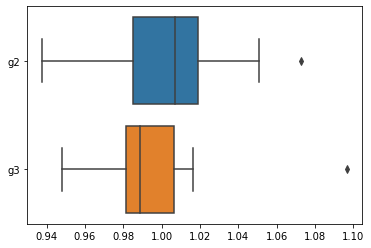

In [ ]:
anomaly_score_g2_vs_g1 = np.array([x[1]/x[0] for x in anomaly_score_by_group_list])
anomaly_score_g3_vs_g1 = np.array([x[2]/x[0] for x in anomaly_score_by_group_list])
sns.boxplot(x=[
               anomaly_score_g2_vs_g1,
               anomaly_score_g3_vs_g1], 
            y=['g2','g3'])

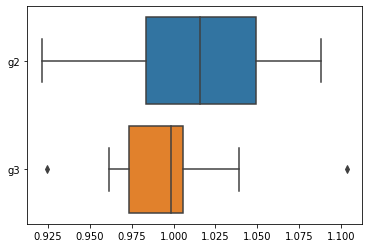

In [ ]:
anomaly_counts_g2_vs_g1 = np.array([x[1]/x[0] for x in anomaly_counts_estimate_by_group_list])
anomaly_counts_g3_vs_g1 = np.array([x[2]/x[0] for x in anomaly_counts_estimate_by_group_list])
sns.boxplot(x=[
               anomaly_counts_g2_vs_g1,
               anomaly_counts_g3_vs_g1], 
            y=['g2','g3'])